## Functions :
-***loadData*** : Load data from csv datasets 

-***visualizeData*** : Have a small insight on the Data

-***Df2Numpy*** : Converts pandas Dataframe to numpy array
***



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
import time


def dataAnalysis(R):
    nUsers = R.shape[0]
    nMovies = R.shape[1]
    
    # Number of rated movies per user
    ratingsPerUser = [sum(R[i, :] > 0) for i in range(nUsers)]
    maxRatingsPerUser = max(ratingsPerUser)
    minRatingsPerUser = min(ratingsPerUser)
    avgRatingsPerUser = sum(ratingsPerUser) / len(ratingsPerUser)
    print("Max ratings per user : ", maxRatingsPerUser)
    print("Min ratings per user : ", minRatingsPerUser)
    print("Avg ratings per user : ", avgRatingsPerUser)
    usersNoRatings = len([u for u in ratingsPerUser if u == 0])
    print("Users with no ratings : ", usersNoRatings)
    
    # Number of ratings per movie
    ratingsPerMovie = [sum(R[:, j] > 0) for j in range(nMovies)]
    maxRatingsPerMovie = max(ratingsPerMovie)
    minRatingsPerMovie = min(ratingsPerMovie)
    avgRatingsPerMovie = sum(ratingsPerMovie) / len(ratingsPerMovie)
    print("Max ratings per movie : ", maxRatingsPerMovie)
    print("Min ratings per movie : ", minRatingsPerMovie)
    print("Avg ratings per movie : ", avgRatingsPerMovie)
    moviesNoRatings = len([m for m in ratingsPerMovie if m == 0])            
    print("Movies with no ratings : ", moviesNoRatings)

def loadData1M(directory):
    """
        Takes as input the directory of the dataset. 
        Outputs two pandas frames: ratings and movies.
    """
    ratings = pd.read_csv(directory + '/ratings.dat', delimiter="::", header=None, usecols=[0, 1, 2])
    ratings.columns = ['userId', 'movieId', 'rating']
    movies = pd.read_csv(directory + 'movies.dat', delimiter="::", header=None)
    return ratings, movies

def loadData(directory):
    """
        Takes as input the directory of the dataset. 
        Outputs two pandas frames: ratings and movies.
    """
    ratings = pd.read_csv(directory + '/ratings.csv', usecols=['userId', 'movieId', 'rating'])
    movies = pd.read_csv(directory + 'movies.csv')
    return ratings, movies

def visualizeData(ratings, movies):
    print('Ratings is a {} Frame'.format(ratings.shape))
    print(ratings.head())
    print('\n')
    print(ratings.describe())
    print('\n')
    print('Movies is a {} Frame'.format(movies.shape))
    print(movies.head())
    
    nUsers = len(ratings['userId'].unique())
    print("There are {} users in the dataset.".format(nUsers))
    nMovies = len(movies['movieId'].unique())
    print("There are {} movies in the dataset.".format(nMovies))
    
    ratings['rating'].hist(bins=50)
    
def Df2Numpy(ratings):
    ratingsMatrix = ratings.pivot(index='userId', columns='movieId', values='rating')
    ratingsMatrix = ratingsMatrix.fillna(0)
    R = ratingsMatrix.to_numpy()
    return R
    
class MatrixFactorization():
    """
        A Simple Matrix Factorization Class.
        Assumes ratings is a m x n Numpy Array. 
        nFactors is the intermediate dimension k of the Matrices U and V.
        lambdaReg and muReg are regularization parameters.
        Blabla..
    """
    def __init__(self, 
                 ratings, 
                 nFactors=10, 
                 lambdaReg=0.0, 
                 muReg=0.0, 
                 withBias=True, 
                 userBiasReg=0.0, 
                 movieBiasReg=0.0,
                 implicitReg=0.0,
                 alpha=0.001, 
                 maxIter=100, 
                 epsilon=0.001, 
                 trainFrac=0.8, 
                 valFrac=0.1, 
                 testFrac=0.1, 
                 mean=0.0, 
                 sd=1.0):
        np.random.seed(0) #Fix seed
        self.R = ratings
        self.nFactors = nFactors
        self.lambdaReg = lambdaReg
        self.muReg = muReg
        self.userBiasReg = userBiasReg
        self.movieBiasReg = movieBiasReg
        self.nUsers, self.nMovies = ratings.shape
        self.alpha = alpha
        self.maxIter = maxIter
        self.U = np.random.normal(size=(self.nUsers, self.nFactors))
        self.V = np.random.normal(size=(self.nMovies, self.nFactors))
        self.userBias = np.zeros(self.nUsers)
        self.movieBias = np.zeros(self.nMovies)
        self.samples = self.matrix2Samples(ratings)
        self.nSamples = len(self.samples)
        self.epsilon = epsilon
        self.trainFrac = trainFrac
        self.valFrac = valFrac
        self.testFrac = testFrac
        self.mean = mean
        self.sd = sd
        self.globalBias = 0
        self.withBias = withBias
        
        self.bU = np.zeros((self.nUsers, self.nFactors + 2))
        self.bV = np.zeros((self.nMovies, self.nFactors + 2))
        
        # Bias with column trick
        self.bU[:, 0:-2] = self.U[:, :]
        self.bU[:, -1] = 1
        self.bV[:, 0:-2] = self.V[:, :]
        self.bU[:, -2] = 1
        
        # Implicit feedbacks 
        self.F = np.zeros((self.nUsers, self.nMovies))
        self.Y = np.zeros((self.nMovies, self.nFactors))
        self.implicitReg = implicitReg
        
    def initF(self, trainSamples):
        for s in trainSamples:
            i, j, r = s
            self.F[i, j] = 1
        
        for i in range(self.nMovies):
            norm = math.sqrt(np.sum(self.F[i, :]))
            if norm != 0.0:
                self.F[i, :] = self.F[i, :] / norm
            
        
    def randomInit(self,mean,sd):
        self.U = np.random.normal(loc=mean, scale=sd, size=(self.nUsers, self.nFactors))
        self.V = np.random.normal(loc=mean, scale=sd, size=(self.nMovies, self.nFactors))
        
    def matrix2Samples(self, R):
        samples = [(i, j, R[i,j]) for i in range(self.nUsers)
           for j in range(self.nMovies) if R[i,j] > 0]
        return samples
    
    def Samples2Matrix(self, samples, m, n):
        matrix = np.zeros(m, n)
        for s in samples:
            i, j, v = s
            matrix[i, j] = v
        return matrix
    
    
    def splitTrainValTestOld(self):
        """
            Shuffle the samples and sends back a partition for training, validation and testing
        """ 
        np.random.shuffle(self.samples)
        nSamples = len(self.samples)
        e1 = math.floor(self.trainFrac * nSamples)
        e2 = math.floor(self.trainFrac * nSamples) + math.floor(self.valFrac * nSamples) 
        
        trainSamples, valSamples, testSamples = self.samples[:e1], self.samples[e1:e2], self.samples[e2:]
        
        # This can be removed if the split is only performed once
        for s in trainSamples:
            i, j, r = s
            self.R[i, j] = r
        
        for s in valSamples:
            i, j, _ = s
            self.R[i, j] = 0
            
        for s in testSamples:
            i, j, _ = s
            self.R[i, j] = 0
            
        # Check if no lost examples
        if nSamples != len(trainSamples) + len(valSamples) + len(testSamples):
            print('ERROR')
        
        return trainSamples, valSamples, testSamples
    
    def splitTrainValTest(self):
        cpt = 0
        trainSamples = []
        valSamples = [] 
        testSamples = []
        for i in range(self.nUsers):
            ratingsIdx = [j for j in range(self.nMovies) if self.R[i, j] > 0]
            np.random.shuffle(ratingsIdx)
            nRatings = len(ratingsIdx)
            e1 = math.floor(self.trainFrac * nRatings)
            e2 = math.floor(self.trainFrac * nRatings) + math.floor(self.valFrac * nRatings) 
            cpt += nRatings
            trainIdx, valIdx, testIdx = ratingsIdx[:e1], ratingsIdx[e1:e2], ratingsIdx[e2:]
            trainSamples.extend([(i, j, self.R[i, j]) for j in trainIdx])
            valSamples.extend([(i, j, self.R[i, j]) for j in valIdx])
            testSamples.extend([(i, j, self.R[i, j]) for j in testIdx])
            
        for s in trainSamples:
            i, j, r = s
            self.R[i, j] = r
        
        for s in valSamples:
            i, j, _ = s
            self.R[i, j] = 0
            
        for s in testSamples:
            i, j, _ = s
            self.R[i, j] = 0
            
        if self.nSamples != len(trainSamples) + len(valSamples) + len(testSamples):
            print('ERROR : ', cpt, ' ', self.nSamples, ' ', len(trainSamples) + len(valSamples) + len(testSamples))

        return trainSamples, valSamples, testSamples
    
    def setGlobalBias(self, trainSamples):
        self.globalBias = sum([s[2] for s in trainSamples]) / len(self.samples)
    
    def splitTrainValSets(self, nGrades=10):
        """
        Split the observed data (nonzero entries) into a training set
        and a validation set by removing 10 grades per user and assigning them
        to the validation set
        """
        valMatrix = np.zeros(self.R.shape)
        trainMatrix = self.R.copy()
        for i in range(self.R.shape[0]):
            valRatingsIds = np.random.choice(self.R[i, :].nonzero()[0],
                                             size=nGrades,
                                             replace=False)
            trainMatrix[i, valRatingsIds] = 0
            valMatrix[i, valRatingsIds] = self.R[i, valRatingsIds]

        assert (np.all(trainMatrix * valMatrix) == 0)
        trainSamples = self.matrix2Samples(trainMatrix)
        valSamples = self.matrix2Samples(valMatrix)
        return trainSamples, valSamples
    
    def trainValTestIdx(self):
        # Returns a partitions of indices 
        nSamples = len(self.samples)
        interval = range(nSamples)
        np.random.shuffle(interval)
        
        e1 = math.floor(self.trainFrac * nSamples)
        e2 = math.floor(self.trainFrac * nSamples) + math.floor(self.valFrac * nSamples) 
        
        trainIdx, valIdx, testIdx = interval[:e1], interval[e1:e2], interval[e2:]
        
        # Check if no lost examples
        if nSamples != len(trainSamples) + len(valSamples) + len(testSamples):
            print('ERROR')
        
        return trainIdx, valIdx, testIdx
    
    def stochasticGradientDescentPass(self, trainSamples):
        #tmpU = np.zeros(self.nFactors)
        #tmpV = np.zeros(self.nFactors)
        for s in trainSamples:
            i, j, r = s
            r_hat_ij = np.dot(self.U[i, :], self.V.T[:, j]) + self.userBias[i] + self.movieBias[j] + self.globalBias
            eij = r - r_hat_ij 
            
            tmpU = self.U[i, :] + self.alpha * (eij * self.V[j, :] - self.lambdaReg * self.U[i, :])
            tmpV = self.V[j, :] + self.alpha * (eij * self.U[i, :] - self.muReg * self.V[j, :])
            
            #for q in range(self.nFactors):
            #    tmpU[q] = self.U[i, q] + self.alpha * (eij * self.V[j, q] - self.lambdaReg * self.U[i, q])
            #    tmpV[q] = self.V[j, q] + self.alpha * (eij * self.U[i, q] - self.muReg * self.V[j, q])
            
            self.U[i, :] = tmpU[:]
            self.V[j, :] = tmpV[:]
            
            if self.withBias:
                self.userBias[i] = self.userBias[i] + self.alpha * (eij - self.userBiasReg * self.userBias[i])
                self.movieBias[j] = self.movieBias[j] + self.alpha * (eij - self.movieBiasReg * self.movieBias[j])
            
        return self.U, self.V
    
    def coordinateDescentIteration(self):
        for i in range(self.nUsers):
            for q in range(self.nFactors):
                self.U[i, q] = sum([(self.R[i, j] - np.dot(self.U[i, :], self.V.T[:, j]) \
                                     + self.U[i, q] * self.V[j, q]) * self.V[j, q] for j in range(self.nMovies) if self.R[i, j] > 0]) \
                                   / (self.lambdaReg + sum([self.V[j, q] ** 2 for j in range(self.nMovies) if self.R[i, j] > 0]))
            if self.withBias:
                self.userBias[i] = sum([self.R[i, j] - np.dot(self.U[i, :], self.V.T[:, j]) \
                 - self.movieBias[j] - self.globalBias \
                  for j in range(self.nMovies) if self.R[i, j] > 0]) / (self.userBiasReg + len([1 for j in range(self.nMovies) if self.R[i, j] > 0])) 
        
        for j in range(self.nMovies):
            for q in range(self.nFactors):
                self.V[j, q] = sum([(self.R[i, j] - np.dot(self.U[i, :], self.V.T[:, j]) \
                                     + self.U[i, q] * self.V[j, q]) * self.U[i, q] for i in range(self.nUsers) if self.R[i, j] > 0]) \
                                    / (self.muReg + sum([self.U[i, q] ** 2 for i in range(self.nUsers) if self.R[i, j] > 0]))
            if self.withBias:
                self.movieBias[j] = sum([self.R[i, j] - np.dot(self.U[i, :], self.V.T[:, j]) \
                  - self.userBias[i] - self.globalBias \
                  for i in range(self.nUsers) if self.R[i, j] > 0]) / (self.movieBiasReg + len([1 for i in range(self.nUsers) if self.R[i, j] > 0]))
                                   
    def coordinateDescent(self, logging=True):
        history = {'trainErrors': [], 'valErrors': []}
        self.randomInit(self.mean, self.sd)
        trainSamples, valSamples, testSamples = self.splitTrainValTest()
        for i in range(self.maxIter):
            self.coordinateDescentIteration()
            
            if logging:
                trainError = self.computeTotalErrorSamples(trainSamples)

                valError = self.computeTotalErrorSamples(valSamples)
                history['trainErrors'].append(trainError)
                history['valErrors'].append(valError)
            #if trainError < self.epsilon:
            #    break
        
        history['trainError'] = self.computeTotalErrorSamples(trainSamples)
        history['valError'] = self.computeTotalErrorSamples(valSamples)

        return self.U, self.V, history

    def gridSearch(self, factors, alphas, lambdaRegs, muRegs):
        lowest_error = math.inf
        best_config = None
        bestSolution = (None, None)
        for config in itertools.product(factors, alphas, lambdaRegs, muRegs):
            self.nFactors, self.alpha, self.lambdaReg, self.muReg = config
            U, V, history = self.stochasticGradientDescent(False)
            if history['valError'] < lowest_error:
                lowest_error = history['valError']
                best_config = config
                bestSolution = (U, V)
                
        self.U, self.V = bestSolution    # Just for consistency 
        
        return U, V, best_config
            
            
    def stochasticGradientDescent(self, logging=True):
        history = {'trainErrors':[], 'valErrors':[]}
        self.randomInit(mean = self.mean, sd = self.sd)
        #self.NonRandomInit()
        trainSamples, valSamples, testSamples = self.splitTrainValTest()  # This should probably be outside ?
        if self.withBias:
            self.setGlobalBias(trainSamples)
        for i in range(self.maxIter):
            # I think we should shuffle the data here. 
            np.random.shuffle(trainSamples)
            U, V = self.stochasticGradientDescentPass(trainSamples)
            
            if logging:
                trainError = self.computeTotalErrorSamples(trainSamples)
                valError = self.computeTotalErrorSamples(valSamples)
                history['trainErrors'].append(trainError)
                history['valErrors'].append(valError)
            #if trainError < self.epsilon:
            #    break
        
        history['trainError'] = self.computeTotalErrorSamples(trainSamples)
        history['valError'] = self.computeTotalErrorSamples(valSamples)

        return U, V, history


    def computeTotalErrorSamples(self, data, bAls=False):
        error = 0
        if len(data) == 0:
            return 0
        if bAls:
            for s in data:
                i, j, r = s
                error += (r - np.dot(self.bU[i, :], self.bV.T[:, j]) - self.globalBias) ** 2
        else:
            for s in data:
                i, j, r = s
                error += (r - np.dot(self.U[i, :], self.V.T[:, j]) - self.userBias[i] - self.movieBias[j] - self.globalBias) ** 2
            
        return math.sqrt(error / len(data))

    def plotHistory(self, history, title): 
        plt.plot(history['trainErrors'], label='Training Error')
        plt.plot(history['valErrors'], label='Validation Error')
        plt.title(title)
        plt.ylabel('RMSE')
        plt.xlabel('Iteration')
        plt.legend()
        plt.show()
        
    def computeApproximatedMatrix(self, U, V):
        return np.dot(U, V.T)
    
    def alsUserStep(self, i):
        if not self.withBias:
            # Try this
            u = np.linalg.solve(sum([np.outer(self.V[j, :], self.V[j, :]) 
                                for j in range(self.nMovies) if self.R[i, j] > 0]) + 
                                   self.lambdaReg * np.eye(self.nFactors), 
                               sum([(self.R[i,j] - self.userBias[i] - self.movieBias[j] - self.globalBias) * self.V[j, :] 
                                    for j in range(self.nMovies) if self.R[i, j] > 0]))
            #u = np.dot(
            #    np.linalg.inv(sum([np.outer(self.V[j, :], self.V[j, :]) 
            #                    for j in range(self.nMovies) if self.R[i, j] > 0]) + 
            #                       self.lambdaReg * np.eye(self.nFactors)), 
            #    sum([(self.R[i,j] - self.userBias[i] - self.movieBias[j] - self.globalBias) * self.V[j, :] for j in range(self.nMovies) if self.R[i, j] > 0])
            #)
        if self.withBias:
            #u = np.dot(
            #    np.linalg.inv(sum([np.outer(self.bV[j, :], self.bV[j, :]) 
            #                    for j in range(self.nMovies) if self.R[i, j] > 0]) + 
            #                       self.lambdaReg * np.eye(self.nFactors + 2)), 
            #    sum([(self.R[i,j] - self.globalBias) * self.bV[j, :] for j in range(self.nMovies) if self.R[i, j] > 0])
            #)
            
            u = np.linalg.solve(sum([np.outer(self.bV[j, :], self.bV[j, :]) 
                                for j in range(self.nMovies) if self.R[i, j] > 0]) + 
                                   self.lambdaReg * np.eye(self.nFactors + 2), 
                               sum([(self.R[i,j] - self.globalBias) * self.bV[j, :] 
                                    for j in range(self.nMovies) if self.R[i, j] > 0]))
            #self.userBias[i] = sum([self.R[i, j] - np.dot(self.U[i, :], self.V.T[:, j]) \
            #     - self.movieBias[j] - self.globalBias \
            #  for j in range(self.nMovies) if self.R[i, j] > 0]) / (self.userBiasReg + len([1 for j in range(self.nMovies) if self.R[i, j] > 0]))
        
        
        # Maybe totally wrong
        # We do we update the biases ? As an independent block vector ? Or one coordinate at the time ?
        #if self.withBias:
        #    self.userBias[i] = sum([self.R[i, j] - np.dot(self.U[i, :], self.V.T[:, j]) \
        #         - self.movieBias[j] - self.globalBias \
        #      for j in range(self.nMovies) if R[i, j] > 0]) / (self.userBiasReg + len([1 for j in range(self.nMovies) if R[i, j] > 0]))
                #self.movieBias[j] = self.movieBias[j] + self.alpha * (eij - self.movieBiasReg * self.movieBias[j])
        return u
    
    def alsMovieStep(self, j):
        #try: 
        if not self.withBias:
            # Try this 
            v = np.linalg.solve(sum([np.outer(self.U[i, :], self.U[i, :]) 
                                for i in range(self.nUsers) if self.R[i, j] > 0]) +
                                   self.muReg * np.eye(self.nFactors), 
                               sum([(self.R[i,j] - self.userBias[i] - self.movieBias[j] - self.globalBias) * self.U[i, :] 
                                    for i in range(self.nUsers) if self.R[i, j] > 0]))
            
            #v = np.dot(
            #np.linalg.inv(sum([np.outer(self.U[i, :], self.U[i, :]) 
            #                    for i in range(self.nUsers) if self.R[i, j] > 0]) +
            #                       self.muReg * np.eye(self.nFactors)), 
            #sum([(self.R[i,j] - self.userBias[i] - self.movieBias[j] - self.globalBias) * self.U[i, :] for i in range(self.nUsers) if self.R[i, j] > 0])
            #)
            
        #else:
        #    extendedU = np.ones(self.nUsers, self.nFactor + 1)
        #    extendedV = np.ones(self.nUsers, self.nFactor + 1)
        #    extendedU[:, 0] = np.ones()
        #    extendedU[1:] = 
        
        # Need to be checked
        if self.withBias:
            v = np.linalg.solve(sum([np.outer(self.bU[i, :], self.bU[i, :]) 
                                for i in range(self.nUsers) if self.R[i, j] > 0]) +
                                   self.muReg * np.eye(self.nFactors + 2), 
                               sum([(self.R[i,j] - self.globalBias) * self.bU[i, :] 
                                    for i in range(self.nUsers) if self.R[i, j] > 0]))
            #v = np.dot(
            #np.linalg.inv(sum([np.outer(self.bU[i, :], self.bU[i, :]) 
            #                    for i in range(self.nUsers) if self.R[i, j] > 0]) +
            #                       self.muReg * np.eye(self.nFactors + 2)), 
            #sum([(self.R[i,j] - self.globalBias) * self.bU[i, :] for i in range(self.nUsers) if self.R[i, j] > 0])
            #)
            
            #self.movieBias[j] = sum([self.R[i, j] - np.dot(self.U[i, :], self.V.T[:, j]) \
            #      - self.userBias[i] - self.globalBias \
            #      for i in range(self.nUsers) if self.R[i, j] > 0]) / (self.movieBiasReg + len([1 for i in range(self.nUsers) if self.R[i, j] > 0]))
        
        return v
    
    def alsIteration(self):
        if self.withBias:
            tmpU = np.zeros((self.nUsers, self.nFactors + 2))
            tmpV = np.zeros((self.nMovies, self.nFactors + 2))
        else:
            tmpU = np.zeros((self.nUsers, self.nFactors))
            tmpV = np.zeros((self.nMovies, self.nFactors))
        
        for i in range(self.nUsers):
            if any([self.R[i, j] > 0 for j in range(self.nMovies)]):
                tmpU[i, :] = self.alsUserStep(i)
                
        if self.withBias:
            tmpU[:, -1] = 1
            self.bU = tmpU
        else:
            self.U = tmpU
            
        for j in range(self.nMovies):
            if any([self.R[i, j] > 0 for i in range(self.nUsers)]):
                tmpV[j, :] = self.alsMovieStep(j)
                
        if self.withBias:
            tmpV[:, -2] = 1
            self.bV = tmpV
        else:
            self.V = tmpV
        
    def als(self, logging=True):
        history = {'trainErrors': [], 'valErrors': []}
        self.randomInit(self.mean, self.sd)
        trainSamples, valSamples, testSamples = self.splitTrainValTest()
        if self.withBias:
            self.setGlobalBias(trainSamples)
        for i in range(self.maxIter):
            #np.random.shuffle(trainSamples)
            self.alsIteration()
            
            if logging:
                trainError = self.computeTotalErrorSamples(trainSamples, bAls=self.withBias)
                valError = self.computeTotalErrorSamples(valSamples, bAls=self.withBias)
                history['trainErrors'].append(trainError)
                history['valErrors'].append(valError)
            #if trainError < self.epsilon:
            #    break
        history['trainError'] = self.computeTotalErrorSamples(trainSamples, bAls=self.withBias)
        history['valError'] = self.computeTotalErrorSamples(valSamples, bAls=self.withBias)
        
        self.U = self.bU[:, :-2]
        self.V = self.bV[:, :-2]
        self.userBias = self.bU[:, -2]
        self.movieBias = self.bV[:, -1]
        
        return self.U, self.V, history
    
    def svd_plus(self, logging=True):
        history = {'trainErrors': [], 'valErrors': []}
        trainSamples, valSamples, testSamples = self.splitTrainValTest()
        for i in range(self.maxIter):
            self.svd_plus_iteration(trainSamples)
            
            if logging:
                trainError = self.computeTotalErrorSamples(trainSamples)
                valError = self.computeTotalErrorSamples(valSamples)
                history['trainErrors'].append(trainError)
                history['valErrors'].append(valError)
            
        history['trainError'] = self.computeTotalErrorSamples(trainSamples)
        history['valError'] = self.computeTotalErrorSamples(valSamples)
    
    def svd_plus_iteration(self, trainSamples):
        tmpU = np.zeros(self.nFactors)
        tmpV = np.zeros(self.nFactors)
        tmpY = np.zeros((self.nMovies, self.nFactors))
        for s in trainSamples:
            i, j, r = s
            Ii = [j for j in range(self.nMovies) if self.F[i, j] > 0]
            fy = np.array([sum([self.Y[h, q] * self.F[i, h] for h in Ii]) for q in range(self.nFactors)])
            r_hat_ij = np.dot(self.U[i, :] + fy, self.V.T[:, j]) 
            eij = r - r_hat_ij
            

            for q in range(self.nFactors):
                tmpU[q] = self.U[i, q] + self.alpha * (eij * self.V[j, q] - self.lambdaReg * self.U[i, q])
                tmpV[q] = self.V[j, q] + self.alpha * (eij * (self.U[i, q] + fy[q]) - self.muReg * self.V[j, q])
                for h in Ii: 
                    tmpY[h, q] = self.Y[h, q] + self.alpha * (eij * self.V[j, q] / self.F[i, h] - self.implicitReg * self.Y[h, q])
                    
            self.U[i, :] = tmpU[:]
            self.V[j, :] = tmpV[:]
            for q in range(self.nFactors):
                for h in Ii:
                    self.Y[h, q] = tmpY[h, q]
            
            
    
# Generates a rank(k) matrix. Should add some noise..    
def syntheticMatrix(m, n, k):
    basis = np.random.randint(3, size=(m, k))
    matrix = np.zeros((m, n))
    coeffs = np.random.randint(3, size=k)
    
    for i in range(n):
        coeffs = np.random.randint(4, size=k)
        matrix[:, i] = sum([coeffs[j] * basis[:, j] for j in range(k)]) # TODO: + some small noise vector
         
    return matrix

In [2]:
plt.style.use('projet.mplstyle')

In [3]:
ratings, movies = loadData('Data/')

In [4]:
# Test SGD without bias
R_sgd = Df2Numpy(ratings)
mf_sgd = MatrixFactorization(R_sgd, 
                             nFactors=5,
                             alpha=0.01,
                             lambdaReg=0.1, 
                             muReg=0.1, 
                             trainFrac=0.8, 
                             valFrac=0.2, 
                             testFrac=0.0,
                             withBias=False,
                            maxIter=100)
U_sgd, V_sgd, history_sgd = mf_sgd.stochasticGradientDescent(True)

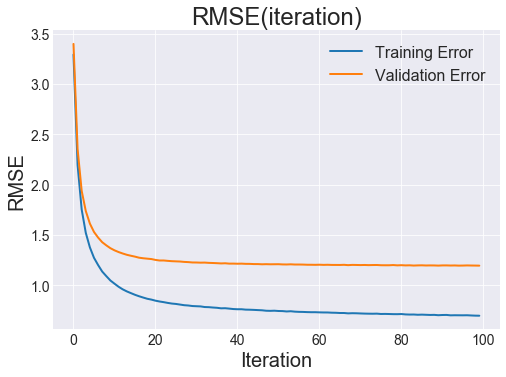

In [7]:
mf_sgd.plotHistory(history_sgd, title='RMSE(iteration)')